In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import clean_reviews as clean
import sklearn
import nltk
from tqdm import tqdm

In [2]:
tqdm.pandas()

In [3]:

# !pip install scikit-learn==1.0.2
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.6.5.
The scikit-learn version is 1.0.2.


In [4]:
df = pd.read_csv('./amz_tshirt_reviews.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40521 entries, 0 to 40520
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  40521 non-null  object 
 1   attr          0 non-null      float64
 2   scores        40441 non-null  object 
 3   review_title  40441 non-null  object 
 4   reviews       40521 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


In [6]:
# using dictionary to convert specific columns
convert_dict = {'product_name': str,
                'attr': str,
				'review_title' : str,
                'reviews' : str
               }
df = df.astype(convert_dict)

#### when I webscrapped the data, I had a bug that caused the 'attr' column to be null, I need to re-run the webscrapping ipynb file and get the complete dataset 

In [7]:
df = df.dropna(axis = 0, how= 'all')

In [8]:
df.shape

(40521, 5)

In [9]:
df.sample(10)

,product_name,attr,scores,review_title,reviews
2768,Hanes Men's Essentials Short Sleeve T-shirt Va...,nan,1.0 out of 5 stars,\nFake Hanes Shirts...Garbage\n,"<span class=""a-size-base review-text review-te..."
31181,"Hanes Men's ComfortSoft Tagless Pocket T's, 6 ...",nan,5.0 out of 5 stars,\nGreat for the price\n,"<span class=""a-size-base review-text review-te..."
38972,"Comfort Colors Men's Adult Short Sleeve Tee, S...",nan,3.0 out of 5 stars,\nNot legit\n,"<span class=""a-size-base review-text review-te..."
9145,Champion Men's Classic Jersey Tee,nan,5.0 out of 5 stars,"\nGood shirt, but color is different from pict...","<span class=""a-size-base review-text review-te..."
9781,Champion Men's Classic Jersey Tee,nan,5.0 out of 5 stars,\nStill Looking Great Clothes 👌...\n,"<span class=""a-size-base review-text review-te..."
27559,Hanes Ultimate Men's 5-Pack Tagless ComfortSof...,nan,3.0 out of 5 stars,\nOne time only\n,"<span class=""a-size-base review-text review-te..."
30739,"Hanes Men's ComfortSoft Tagless Pocket T's, 6 ...",nan,1.0 out of 5 stars,\nDON'T THROW YOUR MONEY AWAY!\n,"<span class=""a-size-base review-text review-te..."
4979,Fruit of the Loom Men's Stay Tucked Crew T-Shirt,nan,5.0 out of 5 stars,\nGood shirts\n,"<span class=""a-size-base review-text review-te..."
27983,Hanes Ultimate Men's 5-Pack Tagless ComfortSof...,nan,5.0 out of 5 stars,\nExcellent\n,"<span class=""a-size-base review-text review-te..."
494,"Gildan Men's Ultra Cotton T-Shirt, Style G2000...",nan,5.0 out of 5 stars,\nGreat quality t-shirt!\n,"<span class=""a-size-base review-text review-te..."


In [10]:
duplicate = df[df.duplicated()]
duplicate.shape


(20457, 5)

In [11]:
df.drop_duplicates(inplace=True)


## Extract review score as int

In [12]:
df.scores.fillna('9')
df.scores = df.scores.str.slice(start = 0, stop =1)

# How many products does this dataset have? 

In [13]:
df.product_name.nunique()

46

# What is the distribution of scores 

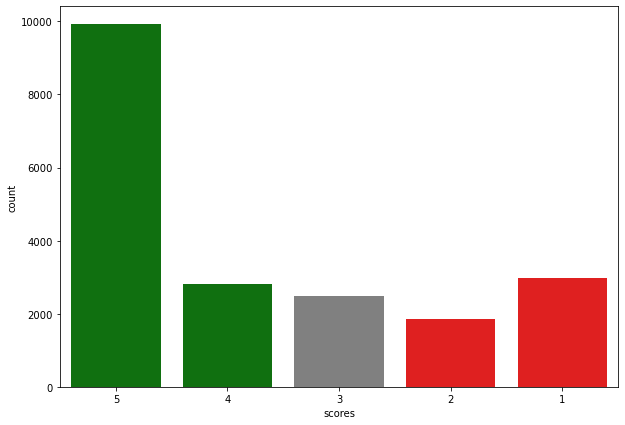

In [14]:
clrs = ['green', 'green', 'grey', 'red', 'red']
sns.countplot( data = df, x = 'scores', order = ['5', '4', '3', '2', '1'], palette=clrs)
# sb.barplot(x=idx, y=values, palette=clrs) # color=clrs)
plt.gcf().set_size_inches(10, 7)



## most of the reviews are 4 and 5 stars.
#### Since we only have few for 1 and 2 stars, I will consider 3 as a bad review. I will create a new boolean column called 'like' which answers the question: 'did the customer like the product or not?'
- 'yes': for 4 & 5 stars ratings
- 'no' :  for 3, 2, and 1 stars 

In [15]:

df.scores.isnull().sum()

38

In [16]:
df.loc[df['scores'].isnull()] = -1
df.scores = df.scores.astype(int)
def like(x):
    if x < 0:
        return None
    else:
        return x > 3

df['like'] = df.scores.apply(like)
df['like'] = df['like'].astype(bool)

<AxesSubplot:xlabel='like', ylabel='count'>

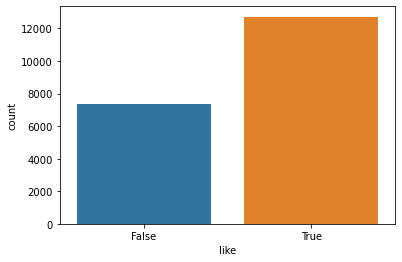

In [17]:
sns.countplot(data=df, x = 'like')

In [18]:
df.like.value_counts()

True     12721
False     7343
Name: like, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20064 entries, 0 to 40454
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  20064 non-null  object
 1   attr          20064 non-null  object
 2   scores        20064 non-null  int64 
 3   review_title  20064 non-null  object
 4   reviews       20064 non-null  object
 5   like          20064 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.4+ MB


In [20]:
#increase the column width to be able to view long reviews 
pd.set_option('max_colwidth', 500)
df['reviews'].sample(2)

36150    <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  Great quality. True to size. No a fake brand. Well worth the price!\n</span>\n</span>
26353                                         <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  Tight around the neck a little\n</span>\n</span>
Name: reviews, dtype: object

## clean 'reviews' & 'review_title' column from <>, \n, punctuations


In [21]:

df.reviews = df.reviews.apply(clean.clean)
df.review_title = df.review_title.apply(clean.clean) 


In [22]:
# !pip install nlppreprocess

In [23]:
# I wanted to split the reviews into sentences but I realized I can do that with nltk
# df['reviews_splitted'] = df.reviews.apply(lambda x: re.split('[,.]', str(x)))

# NLTK

In [24]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, wordnet



[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Lemmatization


In [25]:
lemmatizer = WordNetLemmatizer()
word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lem_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenizer.tokenize(text)]

df['lemmatized_title'] = df['review_title'].apply(lem_text)
df['lemmatized_review'] = df['reviews'].apply(lem_text)



In [69]:
df.lemmatized_review.sample(5)

17296                                                                                                                                                                                                                                                                       [my, favorite, white, shirt, good, quality, and, thick, not, see, through, like, a, lot, of, tshirts, now, if, i, wear, a, black, bra, i, can, see, it, tho, just, stick, to, nude, and, it, is, great, also, very, soft, nice, texture, to, it]
30712    [i, received, these, hanes, tshirts, and, when, i, opened, them, of, the, tshirts, were, an, absolute, mess, hole, and, thread, hanging, everywhere, i, couldnt, believe, they, made, it, through, quality, control, i, called, amazon, and, they, sent, me, a, whole, new, pack, that, were, perfect, and, let, me, keep, the, other, good, one, so, i, got, for, the, price, of, six, best, customer, service, ever, and, i, couldnt, be, happier, update, the, new, one, werent, perfect, i, sh

In [73]:
df.lemmatized_title.head(10)

0                        [solid, value, shirt]
1                              [very, pleased]
2              [hem, roll, up, and, look, bad]
3    [true, xl, no, need, to, go, a, size, up]
4                 [affordable, quality, shirt]
5                                 [thank, you]
6            [cotton, so, buy, next, size, up]
7                               [great, shirt]
8                              [great, choice]
9            [very, stiff, with, wing, sleeve]
Name: lemmatized_title, dtype: object

### stopwords


In [47]:
all_stopwords = stopwords.words('english')

#there are important words in reviews that I don't want to remove, such as "size up" and "size down"
do_not_remove = ['not', 'no', 'up', 'down', 'above', 'below', 'off', 'again', 'too', 'y', 's', 't', 'o', 'd', 'm']
for word in all_stopwords:
    if (word in do_not_remove):
        all_stopwords.remove(word)

def remove_stopwords(text):
    return [word for word in text if word not in all_stopwords]

df['cleaned_review'] = df.lemmatized_review.progress_apply(remove_stopwords)
df['cleaned_title'] = df.lemmatized_title.progress_apply(remove_stopwords)

100%|██████████| 20064/20064 [00:04<00:00, 4489.45it/s]


In [68]:
df.cleaned_review.sample(5)

7443                                                                                                                                                                             [fit, nicely, order, large, size, not, large, think, next, time, order, move, extra, large]
16211                                                                                                                                                                               [bummer, great, shirt, size, too, small, ordered, xl, say, xl, l, graphic, really, nice]
26306                                                                                                                                                                                                                                         [great, quality, great, price]
26197                                                                                                                                                                                            

In [66]:
df.cleaned_title.sample(10)

35985                                                  [shirt]
5260     [shirt, almost, year, still, pretty, much, like, new]
6490                                                [get, pay]
19088                                       [extremely, small]
15254                             [run, small, charge, return]
24206                                       [good, every, way]
6128                            [great, value, great, product]
12371                                                     [ok]
14165                                  [good, value, le, sale]
29064                                        [not, true, size]
Name: cleaned_title, dtype: object

## Stemmer

In [70]:
ps = PorterStemmer()

corpus=[]

for title in df['review_title']:
    title = title.split()
    title = [ps.stem(word) for word in title if not word in set(all_stopwords)]
    title = ' '.join(title)
    corpus.append(title)




In [72]:
corpus[0:10]

['solid valu shirt',
 'pleas',
 'hem roll up look bad',
 'true xl no need go size up',
 'afford qualiti shirt',
 'thank',
 'cotton buy next size up',
 'great shirt',
 'great choic',
 'stiff wing sleev']

## CountVectorizer

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

all_titles = df['review_title'].to_list()
cv = CountVectorizer(stop_words= all_stopwords)
df_cv = cv.fit_transform(all_titles)
df_dtm = pd.DataFrame(df_cv.toarray()    # convert the matrix to an array 
                        , columns=cv.get_feature_names_out()   # name the columns
                        )

df_dtm.index = df.index


In [51]:
df_dtm.sum().sort_values(ascending = False).head(10)


great      2726
shirt      2548
not        2037
good       1999
shirts     1846
quality    1545
fit        1358
nice       1118
size        880
small       817
dtype: int64

In [52]:
all_titles = df['reviews'].to_list()
cv = CountVectorizer(stop_words= all_stopwords, max_df=2000)
df_cv = cv.fit_transform(all_titles)
df_dtm = pd.DataFrame(df_cv.toarray()    # convert the matrix to an array 
                        , columns=cv.get_feature_names_out()   # name the columns
                        )

df_dtm.index = df.index

In [53]:
df_dtm.sum().sort_values(ascending = False).head(10)


cotton     2710
long       2277
little     2239
color      2125
fits       2099
perfect    2071
no         1945
colors     1938
get        1929
fabric     1889
dtype: int64

In [ ]:
# this code results in a very long and unuseful dict
# # finding the most commen 30 words
Top_words = {}
for word in df_dtm.columns:
    a = df_dtm[word].sort_values(ascending=False, na_position='last').head(30)
    Top_words[word]= list(zip(a.index, a.values))



In [76]:
Top_words['aa']

[(18299, 1),
 (0, 0),
 (27172, 0),
 (27179, 0),
 (27178, 0),
 (27177, 0),
 (27176, 0),
 (27175, 0),
 (27174, 0),
 (27173, 0),
 (27171, 0),
 (27181, 0),
 (27170, 0),
 (27169, 0),
 (27168, 0),
 (27167, 0),
 (27166, 0),
 (27165, 0),
 (27164, 0),
 (27180, 0),
 (27182, 0),
 (27162, 0),
 (27183, 0),
 (27198, 0),
 (27197, 0),
 (27196, 0),
 (27195, 0),
 (27194, 0),
 (27193, 0),
 (27192, 0)]

In [ ]:
# ! pip install -U wordcloud

In [58]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=all_stopwords, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

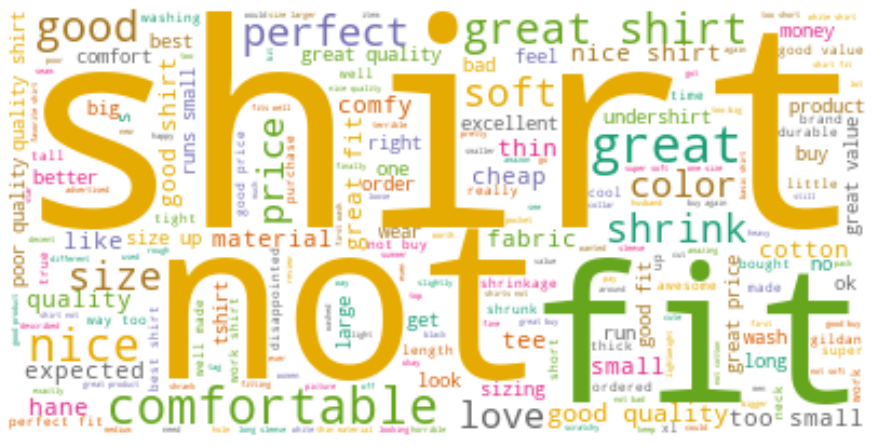

In [61]:
import matplotlib.pyplot as plt

titles = " ".join(title for title in df.review_title)
plt.rcParams['figure.figsize'] = [16, 6]

cloud = wc.generate(titles)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.imshow(cloud, interpolation='bilinear')
plt.show()
